In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
from skimage.util import random_noise
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import random
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)
import matplotlib.pyplot as plt

%matplotlib inline

/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sara/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype s

In [2]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 512
img_cols = 640

smooth = 1.

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def Specificity(y_true, y_pred):
    true_negatives = K.abs(y_pred)- K.abs(y_true)
    return ((true_negatives+smooth)/(y_pred+ smooth))

def Sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return ((y_pred+smooth)/ (y_true+smooth))

def Jaccard_index(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [4]:
batch_size = 32
epochs = 30
target_size = (512,640)

metrics=[dice_coef, 'acc',Jaccard_index, Specificity, Sensitivity, precision, recall, f1score]

sgd_opt = SGD(lr=1E-2, decay=1E-4, momentum=0.9, nesterov=True)
adam_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1E-4)

In [5]:
# we create two instances with the same arguments
train_data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')
train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()

In [6]:
seed = 1
batch_size=10
train_image_generator = train_image_datagen.flow_from_directory(
    'data/training/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    target_size = target_size,
    batch_size=batch_size)

train_mask_generator = train_mask_datagen.flow_from_directory(
    'data/training/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    target_size = target_size,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
train_generator = zip(train_image_generator, train_mask_generator)

val_image_generator = val_image_datagen.flow_from_directory(
    'data/validation/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    target_size = target_size,
    batch_size=batch_size)

val_mask_generator = val_mask_datagen.flow_from_directory(
    'data/validation/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    target_size = target_size,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
val_generator = zip(val_image_generator, val_mask_generator)

Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


In [7]:
from keras.models import *
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation, add, concatenate


def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = add([shortcut, res_path])
    return res_path


def encoder(x):
    to_decoder = []

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = add([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 256], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def decoder(x, from_encoder):
    main_path = UpSampling2D(size=(2, 2))(x)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, [256, 256], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, [128, 128], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, [64, 64], [(1, 1), (1, 1)])

    return main_path


def build_res_unet(input_shape):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    path = res_block(to_decoder[2], [512, 512], [(2, 2), (1, 1)])

    path = decoder(path, from_encoder=to_decoder)

    path = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(path)
    
    return Model(input=inputs, output=path)


In [8]:
input_shape = (512,640,1)
model = build_res_unet(input_shape=input_shape)
model.summary()
model.compile(optimizer=sgd_opt, loss=dice_coef_loss, metrics= metrics)
model_checkpoint = ModelCheckpoint('models/endovis-Deep-Residual-Unet.hdf5', monitor='loss',verbose=1, save_best_only=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 640, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 640, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 640, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 512, 640, 64) 128         input_1[0][0]                    
__________________________________________________________________________________________________
activation

/home/sara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [9]:
num_train_samples= len(train_image_generator.filenames)
num_train_samples

2

In [10]:
num_val_samples= len(val_image_generator.filenames)
num_val_samples

2

In [11]:
experiment_name = "Endovis-UNet"
img_dim = (512,640,1)
dataset='Endovis'
model_name = "Deep-Residual-UNet-SGD"

In [12]:
history = model.fit_generator(train_generator,
                 steps_per_epoch =int(np.ceil(num_train_samples * 1.0 / batch_size)),
                 validation_data = val_generator,
                 validation_steps=int(np.ceil(num_val_samples * 1.0 / batch_size)),
                 callbacks=[model_checkpoint],
                 epochs=epochs)

Epoch 1/5
1/1 [==============================] - 56s 56s/step - loss: -1.0183 - dice_coef: 1.0183 - acc: 0.2592 - Jaccard_index: 1.0373 - Specificity: -37.5618 - Sensitivity: 0.8440 - precision: 0.8806 - recall: 0.9996 - f1score: 0.9363 - val_loss: -1.9603 - val_dice_coef: 1.9603 - val_acc: 0.0023 - val_Jaccard_index: 49.4220 - val_Specificity: -23.7311 - val_Sensitivity: 1.0217 - val_precision: 0.4948 - val_recall: 1.0000 - val_f1score: 0.6620

Epoch 00001: loss improved from inf to -1.01829, saving model to models/endovis-Deep-Residual-Unet.hdf5
Epoch 2/5
1/1 [==============================] - 53s 53s/step - loss: -1.4683 - dice_coef: 1.4683 - acc: 0.1035 - Jaccard_index: 2.7613 - Specificity: -30.0470 - Sensitivity: 0.9885 - precision: 0.5113 - recall: 0.9998 - f1score: 0.6766 - val_loss: -1.4687 - val_dice_coef: 1.4687 - val_acc: 0.1454 - val_Jaccard_index: 2.7644 - val_Specificity: -28.2494 - val_Sensitivity: 0.8513 - val_precision: 0.6433 - val_recall: 0.9923 - val_f1score: 0.780

In [15]:
history.history["val_loss"]

[-1.9603347778320312,
 -1.4687039852142334,
 -1.8542695045471191,
 -1.9310321807861328,
 -1.9497103691101074]

In [16]:
history.history["val_dice_coef"]

[1.9603347778320312,
 1.4687039852142334,
 1.8542695045471191,
 1.9310321807861328,
 1.9497103691101074]

In [17]:
history.history["val_acc"]

[0.0023284913040697575,
 0.1453597992658615,
 0.011119079776108265,
 0.0039520263671875,
 0.0022186278365552425]

In [18]:
history.history["val_Jaccard_index"]

[49.42202377319336,
 2.76438045501709,
 12.723971366882324,
 27.99907684326172,
 38.76970291137695]

In [19]:
history.history["loss"]

[-1.0182913541793823,
 -1.4682729244232178,
 -1.8123899698257446,
 -1.9111881256103516,
 -1.947447657585144]

In [20]:
history.history["dice_coef"]

[1.0182913541793823,
 1.4682729244232178,
 1.8123899698257446,
 1.9111881256103516,
 1.947447657585144]

In [21]:
history.history["acc"]

[0.25918275117874146,
 0.10346069186925888,
 0.014561462216079235,
 0.0074371336959302425,
 0.004528808407485485]

In [22]:
history.history["Jaccard_index"]

[1.0372645854949951,
 2.7613277435302734,
 9.660409927368164,
 21.519559860229492,
 37.05729675292969]

In [23]:
score = model.evaluate_generator(val_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  -1.949710454940796
Test Accuracy:  1.949710454940796


In [24]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

dice_coef: 194.97%


In [25]:
print(history.history.keys())

dict_keys(['val_loss', 'val_dice_coef', 'val_acc', 'val_Jaccard_index', 'val_Specificity', 'val_Sensitivity', 'val_precision', 'val_recall', 'val_f1score', 'loss', 'dice_coef', 'acc', 'Jaccard_index', 'Specificity', 'Sensitivity', 'precision', 'recall', 'f1score'])


In [26]:
test_imgs = val_image_generator.next()
test_masks = val_mask_generator.next()
# Let's visualize some of the outputs 
predictions = model.predict_on_batch(test_imgs)

IndexError: index 2 is out of bounds for axis 0 with size 2

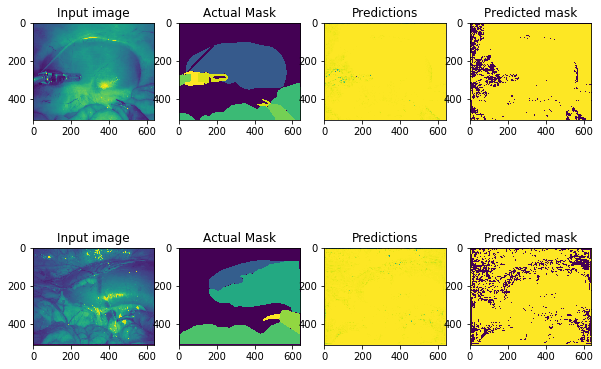

In [27]:
# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
    img = test_imgs[i,:,:,0]
    label = test_masks[i,:,:,0]
    predicted_label = predictions[i,:,:,0]

    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(img)
    plt.title("Input image")

    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(label)
    plt.title("Actual Mask")
    
    plt.subplot(5, 4, 4 * i + 3)
    plt.imshow(predicted_label)
    plt.title("Predictions")
    
    plt.subplot(5, 4, 4 * i + 4)
    plt.imshow(predicted_label>0.99)
    plt.title("Predicted mask")
    
plt.show()

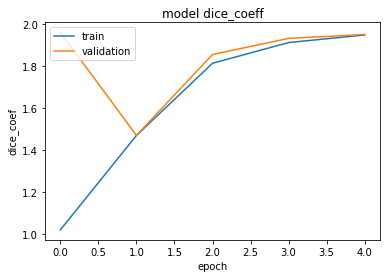

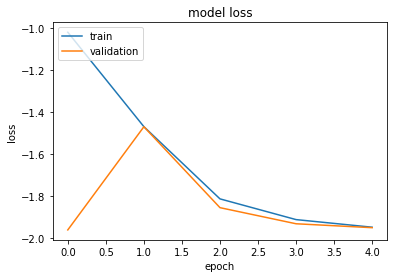

In [28]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coeff')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

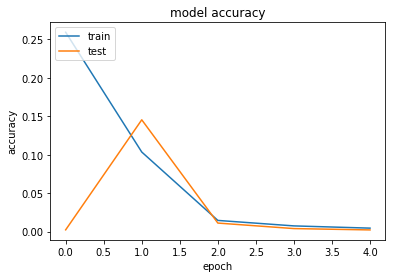

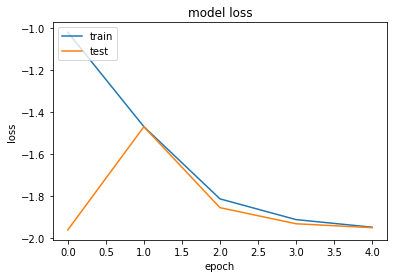

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

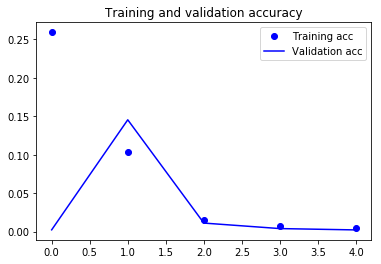

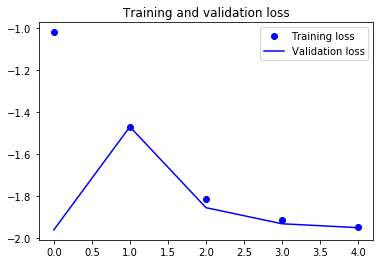

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

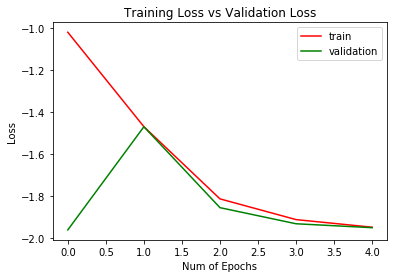

In [31]:
import numpy as np
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')

plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [ ]:
prediction = model.predict_generator(val_generator, verbose=1, steps=10)

 4/10 [===========>..................] - ETA: 2:28

In [ ]:
prediction

In [ ]:
len(prediction)

In [ ]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
#         io.imsave(os.path.join(save_path, str(image_id) + '_pred.png'), img)

In [ ]:
saveResult('results_dir5',prediction)

In [ ]:
# https://github.com/danielelic/deep-hands/blob/59517243823372af4be154ee1f622fcb119f0c59/train_inception-v3.py
print("%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

In [ ]:
print("%s: %.2f%%" % (model.metrics_names[0], score[1] * 100))

In [ ]:
for i in range(1, len(model.metrics_names)):
    print("\nResults validating with training data: %s: %.2f%%" % (model.metrics_names[i], score[i]*100))

In [ ]:
model.save('models/EndoVis-Deep-Residual-Unet-SGD-Model.h5')
model.save_weights('models/EndoVis-Deep-Residual-Unet-SGD-Weights.h5')

___

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('results_dir5/1_predict.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
# https://www.kaggle.com/pestipeti/explanation-of-scoring-metric

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio

from scipy import ndimage
from pathlib import Path

img= plt.imread("data/augmented/image_0_516181.png")
target_mask = plt.imread("data/training/masks/frame000_seq1.png")
pred_mask = plt.imread("results_dir5/1_predict.png")


# Plot the objects
# plt.imshow(im.reshape(im.shape[0], im.shape[1]), cmap=plt.cm.Greys)

fig, axes = plt.subplots(1,3, figsize=(16,9))
axes[0].imshow(img)
axes[1].imshow(target_mask,cmap='jet')
axes[2].imshow(pred_mask, cmap='jet')

labels = ['Original', '"GroundTruth" Mask', '"Predicted" Mask']
for ind, ax in enumerate(axes):
    ax.set_title(labels[ind], fontsize=18)
    ax.axis('off')

In [ ]:
import numpy as np


def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.", "image1 shape:", im1.shape,"image2 shape:", im2.shape)

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [ ]:
groundTruth = plt.imread("data/training/masks/frame000_seq1.png")
resultImage = plt.imread("results_dir5/1_predict.png")

In [ ]:
resultImage = (resultImage - resultImage.min()) / (resultImage.max() - resultImage.min())
groundTruth = (groundTruth - groundTruth.min()) / (groundTruth.max() - groundTruth.min())

In [ ]:
dice(resultImage, groundTruth)

In [ ]:
resultImage.shape

In [ ]:
groundTruth.shape

In [ ]:
groundTruth.ndim , groundTruth.ndim

In [ ]:
target_mask = plt.imread("data/training/masks/frame000_seq1.png")
pred_mask = plt.imread("results_dir5/1_predict.png")

In [ ]:
A = target_mask
B = pred_mask
intersection = np.logical_and(A, B)
union = np.logical_or(A, B)

fig, axes = plt.subplots(1,4, figsize=(18,12))
axes[0].imshow(A, cmap='hot')
axes[0].annotate('npixels = {}'.format(np.sum(A>0)), 
                 xy=(10, 10), color='white', fontsize=12)
axes[1].imshow(B, cmap='hot')
axes[1].annotate('npixels = {}'.format(np.sum(B>0)), 
                 xy=(10, 10), color='white', fontsize=12)

axes[2].imshow(intersection, cmap='hot')
axes[2].annotate('npixels = {}'.format(np.sum(intersection>0)), 
                 xy=(10, 10), color='white', fontsize=12)

axes[3].imshow(union, cmap='hot')
axes[3].annotate('npixels = {}'.format(np.sum(union>0)), 
                 xy=(10, 10), color='white', fontsize=12)

labels = ['GroundTruth', 'Predicted', 'Intersection', 'Union']
for ind, ax in enumerate(axes):
    ax.set_title(labels[ind], fontsize=18)

In [ ]:
def histdata(accuracy):
    numvalues, x = np.histogram(accuracy, bins=np.arange(0,1.1,0.1))
    print("Accuracy  :   No. of predictions\n")
    for i in range(len(numvalues)):
        print("{:03.1f} - {:03.1f} : {:>4}".format(x[i],x[i+1],numvalues[i]))

In [ ]:
histdata(prediction)

In [ ]:
print("Mean Accuracy:",np.mean(prediction))
print("Accuracy > 0.8 :", np.mean(prediction>=0.8)*100,"%")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.spatial.distance import directed_hausdorff

target_mask = plt.imread("data/training/masks/frame000_seq1.png")
pred_mask = plt.imread("results_dir/1_predict.png")

gt = np.asarray(target_mask).astype(np.bool)
pred = np.asarray(pred_mask).astype(np.bool)

intersection = np.logical_and(gt, pred)
print("Dice score: " + str(2. * intersection.sum() / (gt.sum() + pred.sum())))

print("precision: " + str(precision_score(gt.flatten(), pred.flatten())))
print("accuracy: " + str(accuracy_score(gt.flatten(), pred.flatten())))
print("recall: " + str(recall_score(gt.flatten(), pred.flatten())))
print("f1 (Dice): " + str(f1_score(gt.flatten(), pred.flatten())))